# Assignment 9

Neural need huge amount of data to be able to perform well. Huge amount of data means huge computation power... To bypass the fact that we don't own this kind of machine, we will us the transfer leaning. By using a pretrained network (usually on ImageNet) and train it a little bit, we can avoid most of the computationnal power needed to perform our task. We will work on the ResNet network (https://arxiv.org/pdf/1512.03385.pdf) designed in 2014. 
Then, because we know you all have a degree in medicine, we will try our luck bu doing some! We will then retrain the last layer of the network to be able to recognize leopard and cheetah. The cheetah mini database is in the image folder.

In [1]:
from __future__ import print_function, division
import sys
import numpy as np
import time
import os
import json
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset

import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt

plt.ion()   # interactive mode

In [2]:
data_dir = './images/cheetah_data_mini'
TRAIN = 'train'
TEST = 'val'

# ResNet Takes 224x224 images as input, so we resize all of them
data_transforms = {
    TRAIN: transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x), 
        transform=data_transforms[x]
    )
    for x in [TRAIN, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=4,
        shuffle=True, num_workers=4
    )
    for x in [TRAIN, TEST]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, TEST]}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for x in [TRAIN, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)

Loaded 450 images under train
Loaded 162 images under val
Classes: 
['cheetah', 'leopard', 'unknown']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


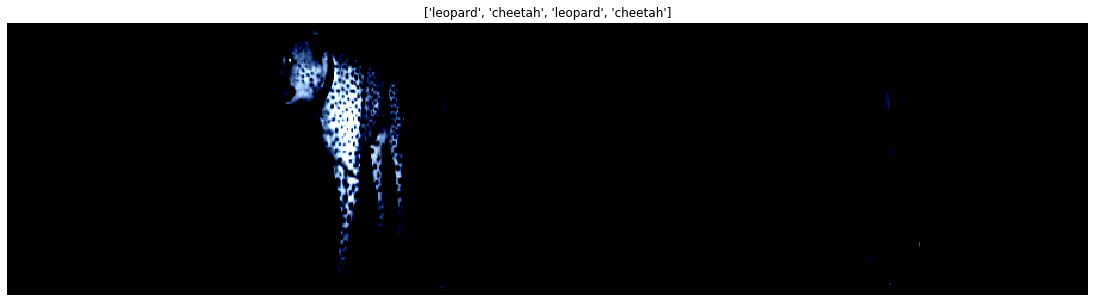

In [3]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(20, 5))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)

## Pretrained network

Now load a network pre-trained on Imagenet and classify the validation data. You can import a pretrained model directly from pytorch with models.resnet18(pretrained=True). The labels are already used in ImageNet so try to recognize the database directly using the output of the pretrained network on the validation database.

In [4]:
with open("./data/imagenet_class_index.json") as file:
    imagenet_dict = json.load(file)

# Mappings:
# 293 -> cheetah
# 288 -> leopard

In [5]:
resnet = models.resnet18(pretrained=True)
resnet.cuda()
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


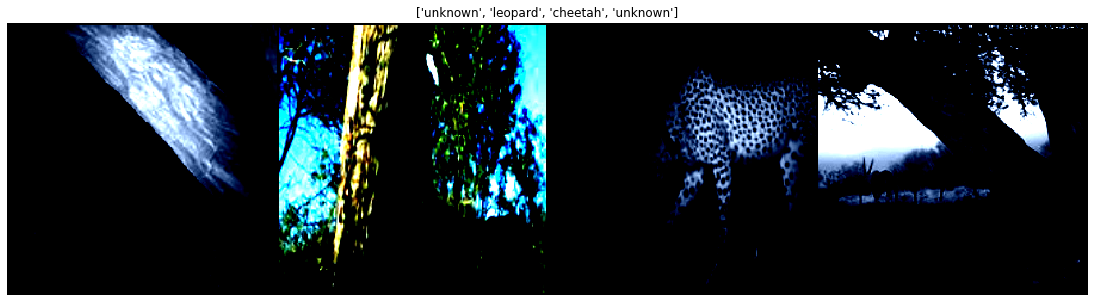

['hog', 'worm_fence', 'cheetah', 'barn']


In [6]:
resnet.eval()
inputs, classes = next(iter(dataloaders[TRAIN]))
classes_pred = torch.argmax(resnet(inputs.cuda()), axis=1).cpu().numpy()
classnames_pred = [imagenet_dict[str(x)][1] for x in classes_pred]

show_databatch(inputs, classes)
print(classnames_pred)

As we can see, the pretrained does not quite predict the desired labels.

## Transfer learning

The pre-trained network can now be further trained with our data. Replace the last layer in the network with a fully connected Layer with 3 outputs for our classes cheetah, leopard and unknown. Then train the last layer of the network.

In [7]:
def set_parameters_requires_grad(model, requires_grad):
    for name, child in resnet.named_children():
        for param in child.parameters():
            param.requires_grad = name == 'layer4'

def get_training_parameters(model):
    params_to_update = model.parameters()
    print("Params to learn:")
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)

    return params_to_update

First, we set the 'requires_grad' parameter of all but the final residual layer to False.

In [8]:
set_parameters_requires_grad(resnet, False)
params = get_training_parameters(resnet)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias


Then, we exchange the last layer of the network.

In [9]:
fc_cheetah = nn.Linear(512, 3)
resnet.fc = fc_cheetah.cuda()

In [10]:
def train(model, training, test=None, lr=1e-2, momentum=0.9, max_epochs=1000, batch_size=100):
    model.train()

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    should_validate = False
    assert isinstance(training, datasets.ImageFolder)
    if not (test is None):
        assert isinstance(test, datasets.ImageFolder)
        should_validate = True

    losses = []
    step = 0
    for t in range(max_epochs):
        sum_loss = 0
        batch_count = 0
        loader = DataLoader(training, batch_size=batch_size, shuffle=True, num_workers=4)
        for x_, y_ in loader:
            x_ = x_.cuda()
            y_ = y_.cuda()
            y_pred = model(x_)
            loss = criterion(y_pred, y_)
            accuracy = (torch.argmax(y_pred, dim=1) == y_).sum().item() / len(y_)

            if should_validate:
                loader_test = iter(DataLoader(test, batch_size=batch_size, shuffle=True, num_workers=4))
                x_test, y_test = next(loader_test)
                x_test = x_test.cuda()
                y_test = y_test.cuda()
                y_pred_test = model(x_test)
                accuracy_test = (torch.argmax(y_pred_test, dim=1) == y_test).sum().item() / len(y_test)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            sum_loss += loss
            batch_count += 1
            avg_loss = sum_loss / batch_count
            step += 1

            if should_validate:
                sys.stdout.write(
                    "\rEpoch: {}, Step: {}, Loss: {:.10f}, Accuracy: {:.2%}, Validation accuracy: {:.2%}".format(t + 1,
                                                                                                                 step,
                                                                                                                 avg_loss,
                                                                                                                 accuracy,
                                                                                                                 accuracy_test))
            else:
                sys.stdout.write(
                    "\rEpoch: {}, Step: {}, Loss: {:.10f}, Accuracy: {:.2%}".format(t + 1, step, avg_loss, accuracy))

        losses.append(avg_loss)

    model.eval()
    return losses

In [11]:
losses = train(resnet, image_datasets['train'], image_datasets['val'], lr=1e-3, momentum=0.9, max_epochs=50, batch_size=100)

Epoch: 50, Step: 250, Loss: 0.0899564847, Accuracy: 100.00%, Validation accuracy: 77.00%

### Some more dropout might be useful, or more data, model is kind of overfitting